# Weather Station — анализ данных (Jupyter)

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text

def get_env(name: str, default: str) -> str:
    v = os.getenv(name)
    return v if v not in (None, "") else default

APP_DB_HOST = get_env("APP_DB_HOST", "app_db")
APP_DB_PORT = get_env("APP_DB_PORT", "5432")
APP_DB_NAME = get_env("APP_DB_NAME", "appdb")
APP_DB_USER = get_env("APP_DB_USER", "appuser")
APP_DB_PASSWORD = get_env("APP_DB_PASSWORD", "apppassword")

print("DB:", f"{APP_DB_USER}@{APP_DB_HOST}:{APP_DB_PORT}/{APP_DB_NAME}")

engine = create_engine(
    f"postgresql+psycopg2://{APP_DB_USER}:{APP_DB_PASSWORD}@{APP_DB_HOST}:{APP_DB_PORT}/{APP_DB_NAME}",
    pool_pre_ping=True,
)
with engine.connect() as conn:
    conn.execute(text("select 1"))
print("Connected.")


DB: appuser@app_db:5432/appdb
Connected.


In [2]:
df = pd.read_sql(
    text("""
        SELECT ts, station_id, temperature_c, humidity_pct, pressure_hpa, wind_speed_mps, wind_dir_deg
        FROM weather_events
        ORDER BY ts DESC
        LIMIT 5000
    """),
    engine
)

df["ts"] = pd.to_datetime(df["ts"], utc=True)
df = df.sort_values("ts")
df.head()


,ts,station_id,temperature_c,humidity_pct,pressure_hpa,wind_speed_mps,wind_dir_deg
4999,2026-01-08 05:24:00.794858+00:00,AMS-01,8.368362,79.275820,1008.40027,2.503929,166
4998,2026-01-08 05:24:01.801895+00:00,AMS-01,8.555199,83.452260,1008.48770,2.581706,170
4997,2026-01-08 05:24:02.803057+00:00,AMS-01,8.539643,84.326580,1008.48040,2.539325,182
4996,2026-01-08 05:24:03.804010+00:00,AMS-01,8.468959,80.221990,1008.59750,2.617293,180
4995,2026-01-08 05:24:04.804705+00:00,AMS-01,8.604555,81.057526,1008.54430,2.584441,177


In [3]:
# Базовая статистика
df.describe(include="all").T


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ts,5000,NaN,NaN,NaN,2026-01-08 06:05:56.532921088+00:00,2026-01-08 05:24:00.794858+00:00,2026-01-08 05:44:54.302147840+00:00,2026-01-08 06:06:05.827548416+00:00,2026-01-08 06:26:57.857653760+00:00,2026-01-08 06:47:49.319512+00:00,NaN
station_id,5000,1,AMS-01,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature_c,5000.0,NaN,NaN,NaN,7.669626,5.851936,7.235618,7.657849,8.083861,9.602868,0.592431
humidity_pct,5000.0,NaN,NaN,NaN,82.865022,72.018394,80.970301,82.881393,84.725775,93.13589,2.790577
pressure_hpa,5000.0,NaN,NaN,NaN,1009.505164,1006.27386,1007.846162,1008.80505,1010.919713,1016.815,2.251908
wind_speed_mps,5000.0,NaN,NaN,NaN,2.371344,0.844065,2.132823,2.347029,2.603798,3.817777,0.36124
wind_dir_deg,5000.0,NaN,NaN,NaN,169.778,0.0,83.0,177.0,246.0,359.0,99.791005


In [4]:
summary = {
    "rows": len(df),
    "min_ts": df["ts"].min(),
    "max_ts": df["ts"].max(),
    "stations": df["station_id"].nunique(),
    "nulls": df.isna().sum().to_dict(),
}
summary


{'rows': 5000,
 'min_ts': Timestamp('2026-01-08 05:24:00.794858+0000', tz='UTC'),
 'max_ts': Timestamp('2026-01-08 06:47:49.319512+0000', tz='UTC'),
 'stations': 1,
 'nulls': {'ts': 0,
  'station_id': 0,
  'temperature_c': 0,
  'humidity_pct': 0,
  'pressure_hpa': 0,
  'wind_speed_mps': 0,
  'wind_dir_deg': 0}}

In [5]:
df_idx = df.set_index("ts")
agg_1m = df_idx.resample("1min").mean(numeric_only=True)
agg_1m.tail()


,temperature_c,humidity_pct,pressure_hpa,wind_speed_mps,wind_dir_deg
ts,,,,,
2026-01-08 06:43:00+00:00,6.962205,84.105329,1008.280214,2.049137,109.508475
2026-01-08 06:44:00+00:00,7.034309,84.162850,1009.000856,2.124619,95.883333
2026-01-08 06:45:00+00:00,6.960054,84.316160,1009.379231,2.459846,165.183333
2026-01-08 06:46:00+00:00,7.003188,83.809113,1009.116356,2.556893,153.350000
2026-01-08 06:47:00+00:00,6.982291,84.254422,1009.616833,2.368054,131.780000


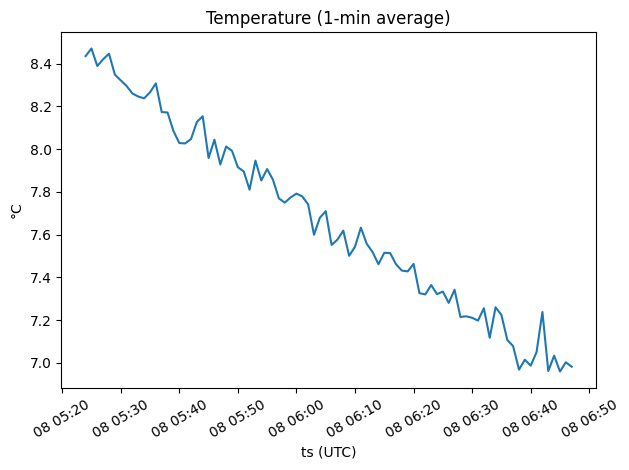

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(agg_1m.index, agg_1m["temperature_c"])
plt.title("Temperature (1-min average)")
plt.xlabel("ts (UTC)")
plt.ylabel("°C")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


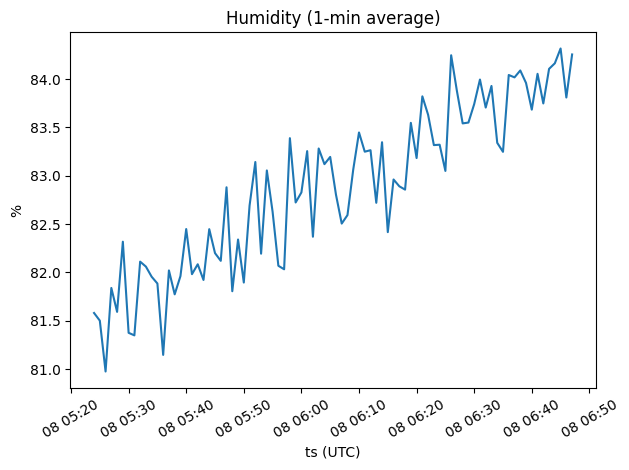

In [7]:
plt.figure()
plt.plot(agg_1m.index, agg_1m["humidity_pct"])
plt.title("Humidity (1-min average)")
plt.xlabel("ts (UTC)")
plt.ylabel("%")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


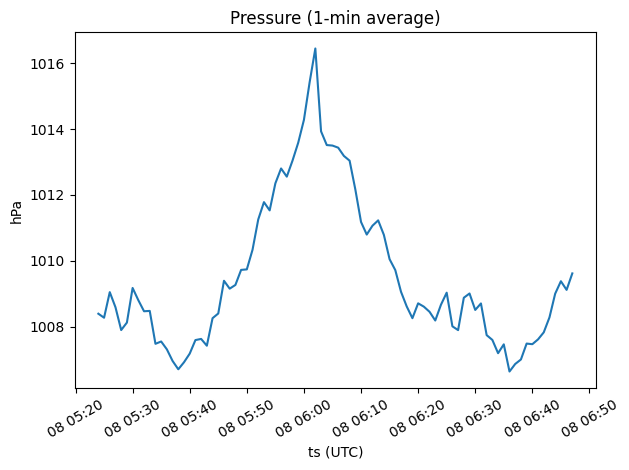

In [8]:
plt.figure()
plt.plot(agg_1m.index, agg_1m["pressure_hpa"])
plt.title("Pressure (1-min average)")
plt.xlabel("ts (UTC)")
plt.ylabel("hPa")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [11]:
df[["temperature_c","humidity_pct","pressure_hpa","wind_speed_mps","wind_dir_deg"]].corr()

,temperature_c,humidity_pct,pressure_hpa,wind_speed_mps,wind_dir_deg
temperature_c,1.000000,-0.389154,0.034256,-0.016905,-0.059111
humidity_pct,-0.389154,1.000000,-0.006559,-0.003884,0.020403
pressure_hpa,0.034256,-0.006559,1.000000,-0.048975,-0.292877
wind_speed_mps,-0.016905,-0.003884,-0.048975,1.000000,0.097297
wind_dir_deg,-0.059111,0.020403,-0.292877,0.097297,1.000000


## Быстрая проверка: данные поступают
Проверка поступления данных


In [ ]:
pd.read_sql(text("SELECT count(*) AS n FROM weather_events;"), engine)
